In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a random square wave signal with random parameters
def generate_random_square_signal(length):
    frequency = np.random.uniform(1, 10)
    amplitude = np.random.uniform(0.5, 2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = amplitude * (1 - 2 * (np.floor(frequency * t) % 2))
    return normalize_signal(signal)

# Generate a random sawtooth signal with random parameters
def generate_random_sawtooth_signal(length):
    frequency = np.random.uniform(1, 10)
    amplitude = np.random.uniform(0.5, 2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = amplitude * (2 * (frequency * t - np.floor(frequency * t + 0.5)))
    return normalize_signal(signal)

# Generate a random noisy signal with random parameters
def generate_random_noisy_signal(length):
    amplitude = np.random.uniform(0.5, 2)
    noise_level = np.random.uniform(0.05, 0.5)
    signal = amplitude * np.random.rand(length) + noise_level * np.random.randn(length)
    return normalize_signal(signal)

# Generate a random sinusoidal signal with random parameters
def generate_random_sinusoidal_signal(length):
    frequency = np.random.uniform(1, 10)
    amplitude = np.random.uniform(0.5, 2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = amplitude * np.sin(2 * np.pi * frequency * t)
    return normalize_signal(signal)

# Generate a random affine (ramp) signal with random parameters
def generate_random_affine_signal(length):
    slope = np.random.uniform(0.2, 2)
    intercept = np.random.uniform(-0.2, 0.2)
    t = np.linspace(0, 1, length, endpoint=False)
    signal = slope * t + intercept
    return normalize_signal(signal)

def normalize_signal(signal):
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        normalized_signal = signal / max_val
        return normalized_signal
    else:
        return signal  # Handle the case where the signal is all zeros to avoid division by zero

In [49]:
signal_length = 20


# Specify the number of signals for each type
num_square_signals = 50
num_sawtooth_signals = 4
num_noisy_signals = 10
num_sinusoidal_signals = 20
num_affine_signals = 1

# Generate signals for each type
square_signals = [generate_random_square_signal(signal_length) for _ in range(num_square_signals)]
square_signals = np.array(square_signals)
sawtooth_signals = [generate_random_sawtooth_signal(signal_length) for _ in range(num_sawtooth_signals)]
sawtooth_signals = np.array(sawtooth_signals)
noisy_signals = [generate_random_noisy_signal(signal_length) for _ in range(num_noisy_signals)]
noisy_signals = np.array(noisy_signals)
sinusoidal_signals = [generate_random_sinusoidal_signal(signal_length) for _ in range(num_sinusoidal_signals)]
sinusoidal_signals = np.array(sinusoidal_signals)
affine_signals = [generate_random_affine_signal(signal_length) for _ in range(num_affine_signals)]
affine_signals = np.array(affine_signals)



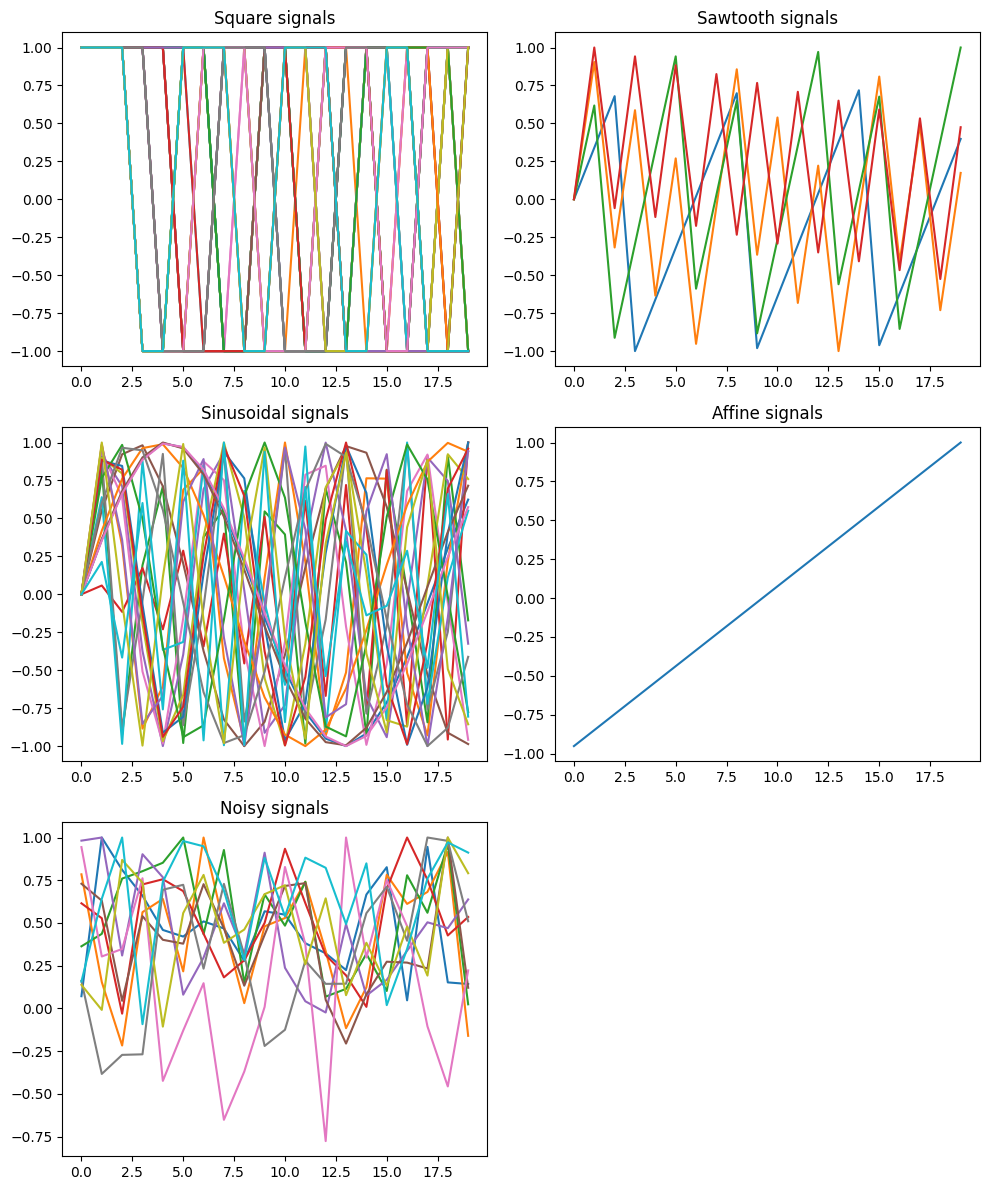

In [50]:
import matplotlib.pyplot as plt

# Plot the signals
plt.figure(figsize=(10, 12))  # Adjust the figure size to accommodate the extra subplot

# Square signals
plt.subplot(3, 2, 1)
for signal in square_signals:
    plt.plot(signal)
plt.title('Square signals')

# Sawtooth signals
plt.subplot(3, 2, 2)
for signal in sawtooth_signals:
    plt.plot(signal)
plt.title('Sawtooth signals')

# Sinusoidal signals
plt.subplot(3, 2, 3)
for signal in sinusoidal_signals:
    plt.plot(signal)
plt.title('Sinusoidal signals')

# Affine signals
plt.subplot(3, 2, 4)
for signal in affine_signals:
    plt.plot(signal)
plt.title('Affine signals')

# Noisy signals
plt.subplot(3, 2, 5)
for signal in noisy_signals:
    plt.plot(signal)
plt.title('Noisy signals')

plt.tight_layout()
plt.show()


In [51]:
# divide those signal in sub signal
sub_signal_length = 20
sinusoidal_signals = sinusoidal_signals.reshape(-1, sub_signal_length)
square_signals = square_signals.reshape(-1, sub_signal_length)
sawtooth_signals = sawtooth_signals.reshape(-1, sub_signal_length)
noisy_signals = noisy_signals.reshape(-1, sub_signal_length)
affine_signals = affine_signals.reshape(-1, sub_signal_length)
print(f"sinusoidal_signals.shape: {sinusoidal_signals.shape}")
print(f"square_signals.shape: {square_signals.shape}")


sinusoidal_signals.shape: (20, 20)
square_signals.shape: (50, 20)


In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64,num_layers=3,bidirectional=False):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    print(f"hidden_dim: {self.hidden_dim}")
    self.num_layers = num_layers
    self.bidirectional = bidirectional

    self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )


    multiple_bi = 2 if bidirectional else 1

    self.rnn2 = nn.LSTM(
          input_size=multiple_bi * self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=self.num_layers,
          batch_first=True
    )

  def forward(self, x):
    batch_size, seq_len, n_features = x.size()
    #x = x.reshape((batch_size * seq_len, n_features))
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    # keep only the last layer
    hidden_n = hidden_n[-1,:,:].unsqueeze(1)
    return hidden_n



class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1,num_layers=3,bidirectional=False):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=self.num_layers,
          batch_first=True,
            bidirectional=self.bidirectional
        )

    multiple_bi = 2 if bidirectional else 1
    self.rnn2 = nn.LSTM(
      input_size=input_dim * multiple_bi,
      hidden_size=self.hidden_dim,
      num_layers=self.num_layers,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):


    batch_size = x.size(0)
    # x is shape (batch_size, 1, n_features)
    # repeat the last dimension to have (batch_size, seq_len, n_features)
    x = x.repeat(1, self.seq_len, 1)
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((batch_size,self.seq_len, self.hidden_dim))
    # keep only the last layer


    return self.output_layer(x)

In [54]:
class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.encoder = Encoder(seq_len, n_features, embedding_dim,bidirectional=True).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features,bidirectional=True).to(device)
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    x = nn.Tanh()(x)
    return x

In [55]:
model = RecurrentAutoencoder(sub_signal_length, 1, 256)
print(f"model : {model}")

hidden_dim: 512
model : RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, bidirectional=True)
    (rnn2): LSTM(1024, 256, num_layers=3, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(256, 256, num_layers=3, batch_first=True, bidirectional=True)
    (rnn2): LSTM(512, 512, num_layers=3, batch_first=True)
    (output_layer): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [56]:
# try with sinusoidal signal
latent_dim = 1
# take only square and sinusoidal signals

signals_concat = np.concatenate((sinusoidal_signals, square_signals, sawtooth_signals, affine_signals), axis=0)
signal_to_tensor = torch.from_numpy(signals_concat).float().unsqueeze(2)
print(f"Input shape: {signal_to_tensor.shape}")
print(f"Input shape: {signal_to_tensor.shape}")

output = model(signal_to_tensor)
print(f"Input shape: {signal_to_tensor.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([75, 20, 1])
Input shape: torch.Size([75, 20, 1])
Input shape: torch.Size([75, 20, 1])
Output shape: torch.Size([75, 20, 1])


(20,)


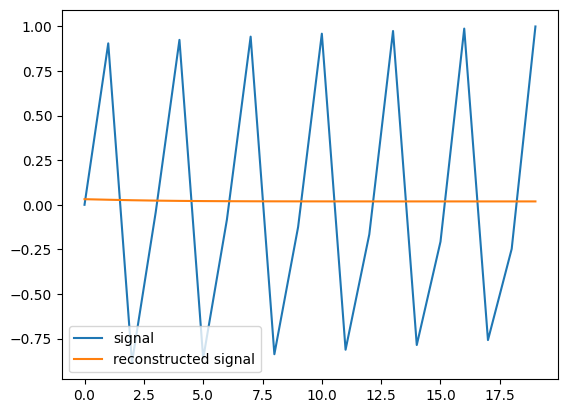

In [57]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, signals_concat.shape[0])
output_decoded = output[random_index].squeeze().detach().numpy()
# take the first signal
signal = signal_to_tensor[random_index].squeeze().detach().numpy()
print(signal.shape)
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()


In [67]:
# try a simple overfitting
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
#loss_fn = nn.L1Loss(reduction='sum')
loss_fn = nn.MSELoss(reduction='sum')
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(signal_to_tensor)

    loss = loss_fn(output, signal_to_tensor)
    loss.backward()
    # visualize the gradients of the last lstm layer

    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, loss: {loss.item()}')

Epoch: 0, loss: 701.9388427734375


KeyboardInterrupt: 

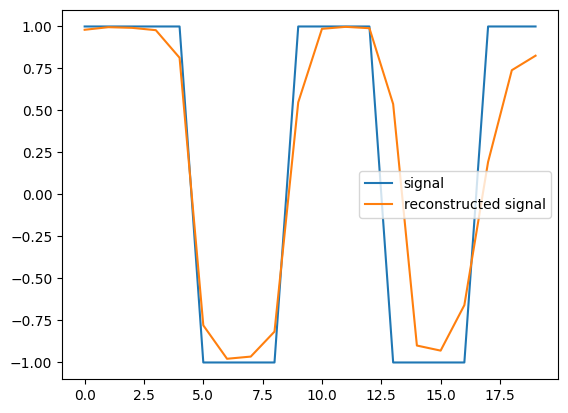

In [66]:
# plot the reconstruction
# get a random signal
random_index = np.random.randint(0, signals_concat.shape[0])
output_decoded = output[random_index].squeeze().detach().numpy()
# take the first signal
signal = signal_to_tensor[random_index].squeeze().detach().numpy()
plt.plot(signal, label='signal')
plt.plot(output_decoded, label='reconstructed signal')
plt.legend()
plt.show()
